In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Set the style for visualizations
sns.set(style="darkgrid")

# Enable inline plotting for matplotlib
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Environment setup complete!")

Environment setup complete!


- **state[0]: Current Price of an Asset**
  - This value represents the most recent trading price of a specific asset. It is crucial for making immediate buy or sell decisions.

- **state[1]: Highest Price of the Asset in the Last Period**
  - Monitoring the highest price within a specific time frame helps in assessing volatility and potential price ceilings.

- **state[2]: Moving Average of the Asset Price**
  - The moving average smooths out price data by creating a constantly updated average price, which is beneficial for identifying trends.

- **state[3]: Volume of the Asset Being Traded**
  - Trading volume indicates the total quantity of an asset that was traded in a given time period and is a measure of the asset's liquidity, often used to confirm trends or signals derived from price movements.
  
- actions: buy, sell hold

In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device count: 2
Current CUDA device: 0
Device name: Tesla T4


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


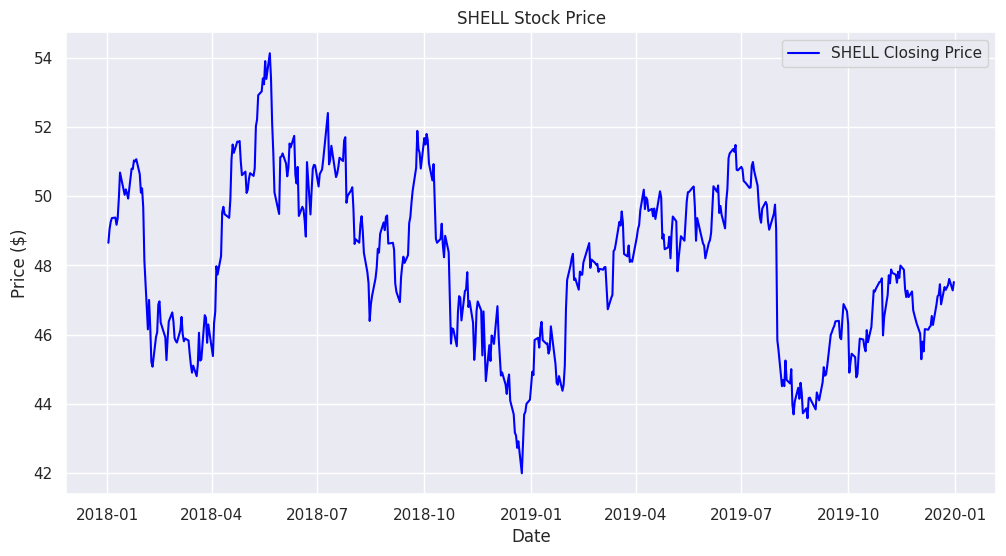

In [3]:
# Get stock data
data = yf.download("SHEL", start="2018-01-01", end="2020-01-01")

# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='SHELL Closing Price', color='blue')
plt.title('SHELL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,SHEL,SHEL,SHEL,SHEL,SHEL
Date,,,,,
2018-01-02,48.655617,48.691369,47.847552,47.911909,3470654
2018-01-03,49.048904,49.120419,48.569787,48.569787,3483320
2018-01-04,49.263439,49.392158,49.056059,49.070364,2638891
2018-01-05,49.370708,49.420765,49.039972,49.191933,2562434
2018-01-08,49.385006,49.399311,49.120421,49.199083,2741832


# Train-test split


For time series data (especially financial data), you should split first, then transform - but with important considerations:

## Correct Order of Operations
1. First split your raw data into train/test sets

2. Then transform/scale each set separately using only **training** statistics

3. Never let test data influence your transformations

## Why This Matters
1. Prevents data leakage (test set information contaminating training)

2. Simulates real-world conditions where future data is unavailable

3. Maintains the temporal order of financial data

In [4]:
# 1. First split data chronologically

split_idx = int(len(data) * 0.8)
train_raw = data.iloc[:split_idx]
test_raw = data.iloc[split_idx:]



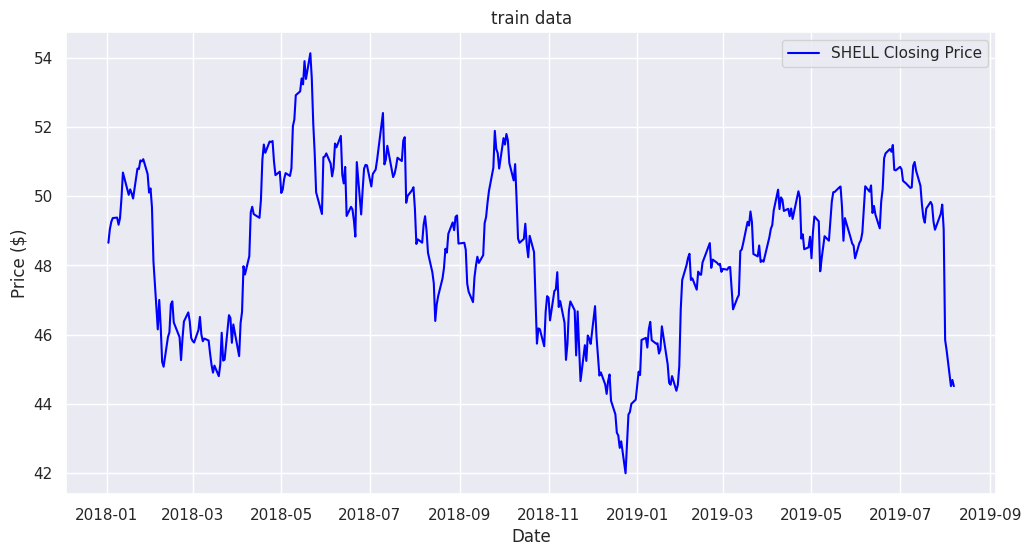

In [7]:
# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(train_raw['Close'], label='SHELL Closing Price', color='blue')
plt.title('train data')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

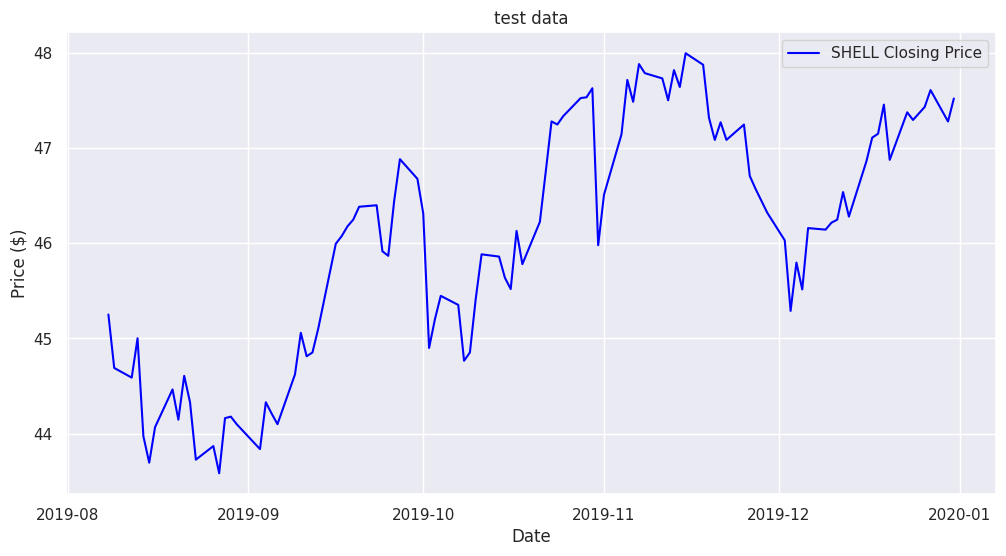

In [8]:
# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(test_raw['Close'], label='SHELL Closing Price', color='blue')
plt.title('test data')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
train_raw.isna().sum()

Price   Ticker
Close   SHEL      0
High    SHEL      0
Low     SHEL      0
Open    SHEL      0
Volume  SHEL      0
dtype: int64

In [5]:
print("Raw volume stats:")
print(train_raw['Volume'].describe())

Raw volume stats:
Ticker          SHEL
count   1.207000e+03
mean    4.661514e+06
std     2.453116e+06
min     7.529140e+05
25%     3.039531e+06
50%     4.216635e+06
75%     5.604991e+06
max     2.149896e+07


# Scaling dataset for numerical stability

When scaling time series data for neural networks (especially for online learning), you need to be careful about data leakage - where future information accidentally influences your scaling of past data. 



In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def create_global_scalers(train_raw):
    """Create scalers fitted on the entire training set"""
    # Initialize scalers
    price_scaler = StandardScaler()  # For prices and highs
    volume_scaler = MinMaxScaler()   # For volumes
    
    # Fit on training data
    price_features = train_raw[['Close', 'High']].values
    price_scaler.fit(price_features)
    
    volume_features = train_raw['Volume'].values.reshape(-1, 1)
    volume_scaler.fit(volume_features)
    
    return price_scaler, volume_scaler

def apply_scaling(data, price_scaler, volume_scaler, ma_window=10):
    """Apply pre-fit scalers to any dataset"""
    prices = data['Close'].values
    high = data['High'].values
    volumes = data['Volume'].values
    
    # Calculate MA (still using rolling window)
    MA = np.array([np.mean(prices[max(0,t-ma_window):t+1]) for t in range(len(prices))])
    
    # Scale features
    price_features = price_scaler.transform(np.column_stack([prices, high]))
    scaled_volumes = volume_scaler.transform(volumes.reshape(-1, 1))
    
    return np.column_stack([price_features, MA, scaled_volumes])

# Usage
price_scaler, volume_scaler = create_global_scalers(train_raw)
train_data = apply_scaling(train_raw, price_scaler, volume_scaler)
test_data = apply_scaling(test_raw, price_scaler, volume_scaler)  # Same scalers!

## The Core Problem of global scaling
Standard scaling approaches use global statistics (whole-dataset mean/std or min/max), which is problematic because:

1. In real trading, you don't know future price ranges when scaling current data

2. Market regimes change - volatility and volume distributions shift over time

3. Using future statistics creates lookahead bias in backtesting

Rolling window approach to scaling does not work yet.

In [10]:
# 2. Apply rolling scaling SEPARATELY to each set
def safe_rolling_scale(data, ma_window=10, scale_window=252):
    """Modified version that respects dataset boundaries"""
    prices = data['Close'].values
    high = data['High'].values
    volumes = data['Volume'].values
    
    MA = np.zeros_like(prices)
    scaled_prices = np.zeros_like(prices)
    scaled_high = np.zeros_like(high)
    scaled_volumes = np.zeros_like(volumes)
    
    for t in range(len(data)):
        # MA calculation remains same
        lookback = max(0, t - ma_window)
        MA[t] = np.mean(prices[lookback:t+1])
        
        # Scaling uses only data up to current point IN THIS DATASET
        price_window = prices[max(0, t-scale_window):t+1]
        price_mean, price_std = price_window.mean(), price_window.std()
        scaled_prices[t] = (prices[t] - price_mean) / (price_std + 1e-8)
        
        high_window = high[max(0, t-scale_window):t+1]
        high_mean, high_std = high_window.mean(), high_window.std()
        scaled_high[t] = (high[t] - high_mean) / (high_std + 1e-8)
        
        vol_window = volumes[max(0, t-scale_window):t+1]
        vol_min, vol_max = vol_window.min(), vol_window.max()
        scaled_volumes[t] = (volumes[t] - vol_min) / (vol_max - vol_min + 1e-8)
    
    return np.column_stack((scaled_prices, scaled_high, MA, scaled_volumes))

# 3. Apply to each dataset
train_data = safe_rolling_scale(train_raw)
test_data = safe_rolling_scale(test_raw)  # Uses its own isolated history

In [8]:
# Column-wise statistics (axis=0)
print("\nColumn-wise statistics:")
print("Means:", np.mean(train_data, axis=0))
print("Medians:", np.median(train_data, axis=0))
print("Standard deviations:", np.std(train_data, axis=0))
print("Minimums:", np.min(train_data, axis=0))
print("Maximums:", np.max(train_data, axis=0))
print("25th percentiles:", np.percentile(train_data, 25, axis=0))
print("75th percentiles:", np.percentile(train_data, 75, axis=0))


Column-wise statistics:
Means: [-3.99661892e-16 -6.67145617e-16  4.13854532e+01  1.88402192e-01]
Medians: [ 0.43085281  0.43564761 45.45112055  0.16695815]
Standard deviations: [1.         1.         8.68736021 0.11819602]
Minimums: [-2.70140014 -2.51685702 20.82303827  0.        ]
Maximums: [ 1.51347496  1.48880258 53.34060842  1.        ]
25th percentiles: [-0.79615632 -0.80768251 34.2673958   0.11021943]
75th percentiles: [ 0.79255115  0.78969906 48.22492652  0.23387964]


In [31]:
actions = {0: 'Buy', 1: 'Sell', 2: 'Hold'}

In [44]:
def state_transition_with_action(state, action):
    price, high, ma, volume, cash, holdings = state
    
    # 1. Market dynamics (unchanged)
    next_price = price 
    next_volume = volume
    
    # 2. Apply action (with validation)
    trade_size = 0.1  # 10% of cash/holdings
    new_cash, new_holdings = cash, holdings  # Default: hold
    
    if action == 0:  # Buy
        if cash > 0:  # Only buy if cash available
            max_affordable = cash / price
            buy_amount = min(trade_size * max_affordable, max_affordable)
            cost = buy_amount * price
            new_holdings = holdings + buy_amount
            new_cash = cash - cost
        else:
            action = 2  # Fallback to hold if no cash
    
    elif action == 1:  # Sell
        if holdings > 0:  # Only sell if holdings available
            sell_amount = trade_size * holdings
            new_cash = cash + (sell_amount * price)
            new_holdings = holdings - sell_amount
        else:
            action = 2  # Fallback to hold if no holdings
    
    # 3. Update market features (unchanged)
    next_high = high
    next_ma = ma
    
    next_state = [
        next_price, next_high, next_ma, next_volume,
        new_cash, new_holdings
    ]
    
    return next_state

In [33]:
def reward_function(old_state, new_state):
#     # Old portfolio value
#     old_value = old_state[4] + old_state[5] * old_state[0]  # cash + holdings * price
    
#     # New portfolio value
#     new_value = new_state[4] + new_state[5] * new_state[0]
    
#     # Reward = Profit (with transaction cost penalty)
#     transaction_cost = 0.001 * abs(new_value - old_value)  # 0.1% fee
#     reward = (new_value - old_value) - transaction_cost


    old_value = old_state[4] + old_state[5] * old_state[0]
    new_value = new_state[4] + new_state[5] * new_state[0]
    reward = (new_value - old_value) / old_value  # Percentage return
    
    return reward

## Deep Q Network agent with target network for stability

In [42]:
import torch
import torch.nn as nn
import numpy as np
import random
from collections import deque
import copy  # For deep copying the model

class DQNAgent:
    def __init__(self, state_dim, action_dim, target_update_freq=100):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995  # Slower decay recommended with target network
        self.target_update_freq = target_update_freq  # How often to update target net
        self.train_step_counter = 0  # To track when to update target
        self.training_steps_this_episode = 0
        
        # Main model and target model
        self.model = self._build_model()
        self.target_model = self._build_model()
        self._update_target_model()  # Initialize target with main model weights
        
        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        self.model.to(self.device)
        self.target_model.to(self.device)
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters())
        
    def _build_model(self):
        """Build the neural network model"""
        model = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_dim)
        )
        return model
    
    def _update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.load_state_dict(self.model.state_dict())
        
    def act(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_dim - 1)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))
        
    def reset_episode_stats(self):
        """Call at the start of each episode"""
        self.training_steps_this_episode = 0
    
    def train(self, batch_size=32):
        """Train the model on a batch of experiences"""
        if len(self.memory) < batch_size:
            return
        
        self.training_steps_this_episode += 1  # Increment counter
        
        # Sample batch from memory
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to tensors
        states = torch.FloatTensor(np.array(states)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values using target network
        with torch.no_grad():  # No gradient calculation for target
            next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss and update
        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network periodically
        self.train_step_counter += 1
        if self.train_step_counter % self.target_update_freq == 0:
            self._update_target_model()
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()  # Return loss for monitoring

In [40]:
test_state = [100, 100, 100, 500, 10000, 0]  # price, high, ma, vol, cash, holdings
buy_action = 0
next_state = state_transition_with_action(test_state, buy_action)
print(reward_function(test_state, next_state))  # Should be positive

0.0


In [45]:
# Initialize
state_dim = 6  # price, high, ma, volume, cash, holdings
action_dim = 3  # buy, sell, hold
agent = DQNAgent(state_dim, action_dim)
portfolio = {"cash": 10000, "holdings": 0}
states = train_data

# Performance tracking containers
portfolio_values = []
all_actions = []
episode_metrics = {
    'sharpe': [],
    'max_drawdown': [],
    'cumulative_return': [],
    'action_distribution': []
}

# Benchmark: Buy-and-Hold strategy
initial_price = states[0][0]
final_price = states[-1][0]
buy_and_hold_return = (final_price - initial_price) / initial_price

# Run episodes
for episode in range(200):
    # Reset portfolio each episode
    current_cash = 10000
    current_holdings = 0
    agent.reset_episode_stats()
    
    # Initialize state with first market data + portfolio
    market_state = states[0]
    state = np.concatenate([market_state, [current_cash, current_holdings]])
    
    total_reward = 0
    episode_portfolio_values = []
    episode_actions = []
    
    for t in range(len(states) - 1):
        # Get action
        action = agent.act(state)
        
        # Get NEXT market state (pre-generated)
        next_market_state = states[t + 1]
        
        # Apply action to get next portfolio state
        next_state = state_transition_with_action(state, action)
        
        # IMPORTANT: Overwrite market components with pre-generated data
        next_state[:4] = next_market_state  # price, high, ma, volume
        
        # Calculate reward
        reward = reward_function(state, next_state)
        total_reward += reward
        
        # Track portfolio value and actions
        current_value = state[4] + state[5] * state[0]  # cash + holdings*price
        episode_portfolio_values.append(current_value)
        episode_actions.append(action)
        
        # Store experience and train
        done = (t == len(states) - 2)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        
        # Update state for next iteration
        state = next_state
    
    # Calculate metrics for this episode
    returns = np.diff(episode_portfolio_values) / episode_portfolio_values[:-1]
    sharpe = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
    max_dd = (np.maximum.accumulate(episode_portfolio_values) - episode_portfolio_values).max()
    cum_return = (episode_portfolio_values[-1] - episode_portfolio_values[0]) / episode_portfolio_values[0]
    
    # Get action distribution
    unique, counts = np.unique(episode_actions, return_counts=True)
    action_dist = dict(zip(unique, counts / len(episode_actions)))
    
    # Store metrics
    episode_metrics['sharpe'].append(sharpe)
    episode_metrics['max_drawdown'].append(max_dd)
    episode_metrics['cumulative_return'].append(cum_return)
    episode_metrics['action_distribution'].append(action_dist)
    
    # Print progress
    print(f"Episode {episode}: Return={cum_return:.2%} | Sharpe={sharpe:.2f} | DD={max_dd:.2f} | total reward= {total_reward} | Training Steps={agent.training_steps_this_episode}")

Using device: cuda
Episode 0: Return=-30.58% | Sharpe=1.12 | DD=25884.16 | total reward= 213.58176311262406 | Training Steps=370
Episode 1: Return=0.00% | Sharpe=0.00 | DD=0.00 | total reward= 0.0 | Training Steps=401
Episode 2: Return=477.62% | Sharpe=0.74 | DD=57242.47 | total reward= 101.1509588486053 | Training Steps=401
Episode 3: Return=12.79% | Sharpe=1.15 | DD=37488.20 | total reward= 218.60174606592216 | Training Steps=401
Episode 4: Return=-257.67% | Sharpe=-1.08 | DD=41936.46 | total reward= -84.57765257444022 | Training Steps=401
Episode 5: Return=-203.61% | Sharpe=-0.56 | DD=114958.42 | total reward= -220.0127700040075 | Training Steps=401
Episode 6: Return=-305.15% | Sharpe=-0.79 | DD=67238.96 | total reward= -38.412977146626474 | Training Steps=401
Episode 7: Return=-252.19% | Sharpe=1.12 | DD=42860.12 | total reward= 211.96690500821882 | Training Steps=401
Episode 8: Return=-359.81% | Sharpe=0.78 | DD=116830.71 | total reward= 28.09893403084611 | Training Steps=401
Epis

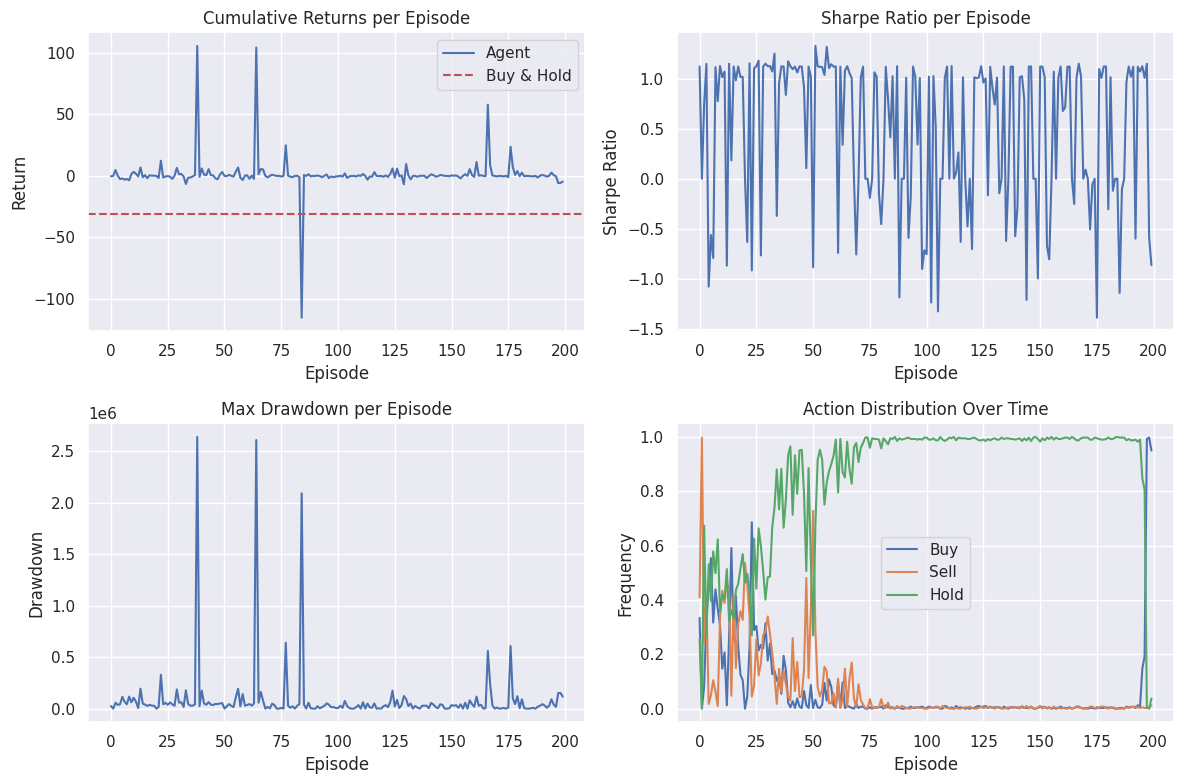

In [46]:
# Plot performance over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Cumulative Returns
plt.subplot(2, 2, 1)
plt.plot(episode_metrics['cumulative_return'], label='Agent')
plt.axhline(y=buy_and_hold_return, color='r', linestyle='--', label='Buy & Hold')
plt.title('Cumulative Returns per Episode')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.legend()

# Sharpe Ratio
plt.subplot(2, 2, 2)
plt.plot(episode_metrics['sharpe'])
plt.title('Sharpe Ratio per Episode')
plt.xlabel('Episode')
plt.ylabel('Sharpe Ratio')

# Max Drawdown
plt.subplot(2, 2, 3)
plt.plot(episode_metrics['max_drawdown'])
plt.title('Max Drawdown per Episode')
plt.xlabel('Episode')
plt.ylabel('Drawdown')

# Action Distribution
plt.subplot(2, 2, 4)
action_counts = np.zeros((len(episode_metrics['action_distribution']), action_dim))
for i, dist in enumerate(episode_metrics['action_distribution']):
    for act, count in dist.items():
        action_counts[i, act] = count
for act in range(action_dim):
    plt.plot(action_counts[:, act], label=actions[act])
plt.title('Action Distribution Over Time')
plt.xlabel('Episode')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def evaluate_agent(agent, test_states, initial_cash=10000):
    """
    Evaluate trained agent on unseen test data
    Returns:
        - portfolio_values: List of portfolio values over time
        - actions_taken: Sequence of actions taken
        - performance_metrics: Dictionary of calculated metrics
    """
    # Initialize
    portfolio = {"cash": initial_cash, "holdings": 0}
    state = np.concatenate([test_states[0], [portfolio["cash"], portfolio["holdings"]]])
    portfolio_values = []
    actions_taken = []
    trade_history = []
    
    # Disable exploration
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    # Run through test data
    for t in range(len(test_states) - 1):
        # Get action (no exploration)
        action = agent.act(state)
        
        # Get NEXT market state (pre-generated)
        next_market_state = states[t + 1]

        
        # Execute action
        next_state = state_transition_with_action(state, action)
        
        # IMPORTANT: Overwrite market components with pre-generated data
        next_state[:4] = next_market_state  # price, high, ma, volume
        
        # Record portfolio value and actions
        current_value = state[4] + state[5] * state[0]  # cash + holdings*price
        portfolio_values.append(current_value)
        actions_taken.append(action)
        
        # Record trades (optional)
        if action != 2:  # Not hold
            trade_history.append({
                'step': t,
                'action': action,
                'price': state[0],
                'shares': abs(next_state[5] - state[5]),
                'value': abs(state[4] - next_state[4])
            })
        
        state = next_state
    
    # Restore original epsilon
    agent.epsilon = original_epsilon
    
    # Calculate performance metrics
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    metrics = {
        'cumulative_return': (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0],
        'annualized_return': (1 + (portfolio_values[-1] - portfolio_values[0])/portfolio_values[0])**(252/len(test_states)) - 1,
        'sharpe_ratio': np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252),
        'max_drawdown': (np.maximum.accumulate(portfolio_values) - portfolio_values).max(),
        'win_rate': np.mean(np.array(returns) > 0),
        'action_distribution': {
            'buy': np.mean(np.array(actions_taken) == 0),
            'sell': np.mean(np.array(actions_taken) == 1),
            'hold': np.mean(np.array(actions_taken) == 2)
        }
    }
    
    return portfolio_values, actions_taken, metrics, trade_history

def plot_performance(test_states, portfolio_values, actions_taken):
    """Visualize agent performance"""
    plt.figure(figsize=(15, 10))
    
    # Price and portfolio value
    prices = [s[0] for s in test_states[:len(portfolio_values)]]
    plt.subplot(2, 2, 1)
    plt.plot(prices, label='Asset Price', alpha=0.7)
    plt.plot(portfolio_values, label='Portfolio Value')
    plt.title('Price vs Portfolio Value')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    
    # Drawdown
    plt.subplot(2, 2, 2)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdown = (running_max - portfolio_values) / running_max
    plt.fill_between(range(len(drawdown)), drawdown, color='red', alpha=0.3)
    plt.title('Drawdown')
    plt.xlabel('Time Step')
    plt.ylabel('Drawdown %')
    
    # Action distribution
    plt.subplot(2, 2, 3)
    action_names = ['Buy', 'Sell', 'Hold']
    action_counts = [np.sum(np.array(actions_taken) == i) for i in range(3)]
    plt.bar(action_names, action_counts)
    plt.title('Action Distribution')
    
    # Cumulative returns
    plt.subplot(2, 2, 4)
    buy_hold_return = (prices[-1] - prices[0]) / prices[0]
    agent_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]
    plt.bar(['Buy & Hold', 'Agent'], [buy_hold_return, agent_return])
    plt.title('Cumulative Returns Comparison')
    plt.ylabel('Return')
    
    plt.tight_layout()
    plt.show()




Performance Metrics:
Cumulative Return: -183.62%
Annualized Return: nan%
Sharpe Ratio: 0.13
Max Drawdown: 28559.96
Win Rate: 52.53%

Action Distribution:
Buy: 100.00%
Sell: 0.00%
Hold: 0.00%


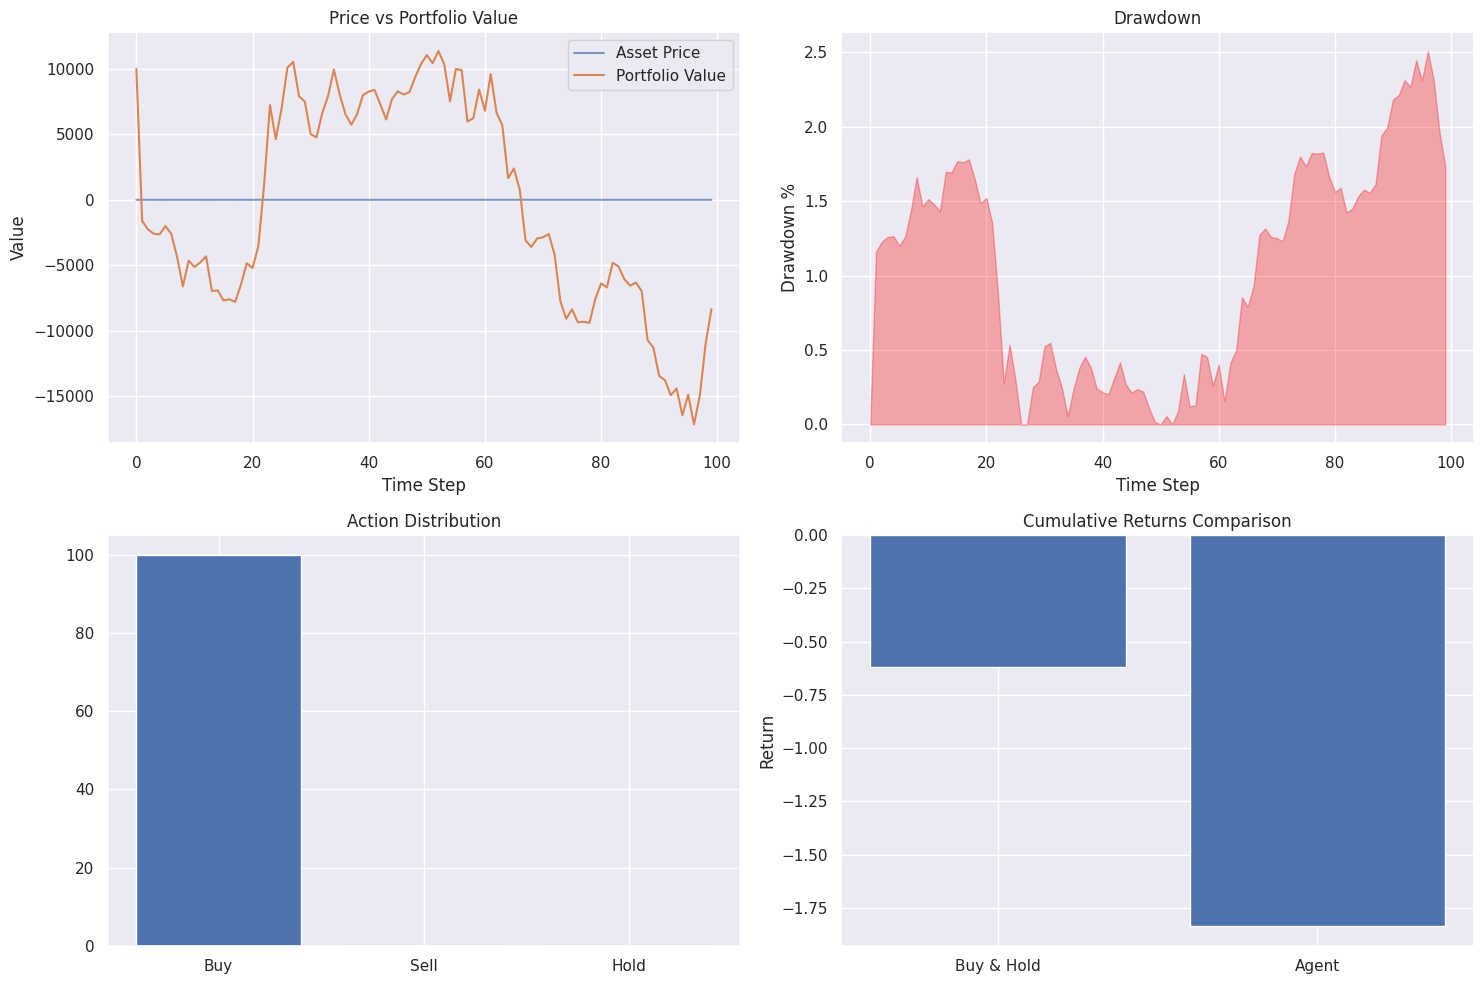


Total Trades Executed: 100
Average Trade Size: $100.00


In [48]:


# 1. Run evaluation
portfolio_values, actions_taken, metrics, trades = evaluate_agent(agent, test_data)

# 2. Print metrics
print("\nPerformance Metrics:")
print(f"Cumulative Return: {metrics['cumulative_return']:.2%}")
print(f"Annualized Return: {metrics['annualized_return']:.2%}")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {metrics['max_drawdown']:.2f}")
print(f"Win Rate: {metrics['win_rate']:.2%}")
print("\nAction Distribution:")
print(f"Buy: {metrics['action_distribution']['buy']:.2%}")
print(f"Sell: {metrics['action_distribution']['sell']:.2%}")
print(f"Hold: {metrics['action_distribution']['hold']:.2%}")

# 3. Plot results
plot_performance(test_data, portfolio_values, actions_taken)

# 4. Optional: Analyze individual trades
print(f"\nTotal Trades Executed: {len(trades)}")
if trades:
    avg_trade_size = np.mean([t['value'] for t in trades])
    print(f"Average Trade Size: ${avg_trade_size:.2f}")

# Module 2.1: Market Data Collection and Preparation 
Collect and preprocess historical market data for a portfolio of assets. Clean the data, remove inconsistencies, and fill in missing values. Create a dataset that can be used for training and evaluating your DRL trading agent.
Give a short descriptive analysis of the data (e.g. histogram of returns, summary statistics)

# Module 2.2: Benchmark Policy Design

You will design at least one benchmark policy. Naturally, the higher the quality of the benchmark, the better you can evaluate the performance of the RL algorithm.

* Create one or more benchmark policies (e.g., a rule-based trading heuristic). You might opt for extremely simple baseline heuristics (single decision rule), but advanced solutions are assessed positively.
* Explain the decision rules you incorporate and how they anticipate the future.
* You can use this benchmark to evaluate the quality of the RL algorithms you design from here on.
* Note you can define multiple benchmarks. Simple decision rules offer a sanity check and a lower bound, more advanced heuristics may be competitive with RL.

# Module 3.1: RL Algorithms Assessment
Critically assess why dynamic programming and tabular Q-learning/SARSA would struggle to provide policies for the problem at hand. Explain what modifications would be needed for these methods to solve the problem, and what impact these modifications would have on the solution.

# Module 3.2: DRL Algorithm Selection and Implementation
Select a suitable DRL algorithm for your trading agent, taking into account the state representation, action space, and non-stationary nature of financial markets. Implement the chosen algorithm using a deep learning framework like TensorFlow or PyTorch.

# Module 4: Reward Function Design and Agent Training

Design a reward function that encourages your trading agent to achieve high returns while managing risk effectively. Train your agent using the prepared market data, adjusting hyperparameters and reward functions as needed to improve learning.

# Module 5: Agent Evaluation and Refinement

Evaluate the performance of your trained trading agent using out-of-sample market data. Analyze its risk-adjusted performance metrics and ensure that its performance is robust and not the result of overfitting or lookahead bias. Refine the agent and iterate through the previous steps as needed to improve its performance.

# Module 6: Trading Strategy Analysis and Interpretation

Analyze the trading strategies learned by your agent and interpret its decisions in the context of market dynamics and asset characteristics. Identify any interesting patterns or insights that can be gained from the agent's behavior.

# Module 7: Reflection and key findings
Summarize your key findings and reflect on your work.
* How well does your final model perform? Can you compare performance to other policies?
* What discrepancies exist between your model and a real-world variant of your problem?
* How did you address the dimensionality challenges? 
* What computational limits did you encounter?
* What future improvement steps could be taken?

# Module 8: Bonus
Write the report using overleaf/ latex. Add all charts and follow this structure:
- Introduction
- Literature Review
(very short on existing literature on deep RL trading strategies)
- Theoretical foundations
(very short on the algo you used, likely Deep RL. No need to explain all concepts from RL again.)
- Data
(very short, the data you used, plus some summary statistics)
- Implementation
(the exact implementation you did. Be very specific here, what parameters, how many training iterations)
- Results
(outcome and interpretation of results)
- Conclusion
(summary and next steps)
- Bibliography 
- Appendix: Code (or link to github for the code)

For all group assignments and presentations, it holds that you should hand in/present your own and original work, in line with the Rules & Guidelines of the Examination Board. You have to add an “author contribution & use of AI statement” to the group assignment.

# Author contribution statement
The author contribution statement should include who did what (tasks) and what was the relative contribution of each group member to the overall contribution (percentage). Also, all group members should agree on the final version of the assignment.

## Example author contribution statement:
* Name group member 1: Wrote the introduction of the report, produced the mathematical model of Module 1, downloaded and cleaned the data, produced output statistics and wrote answers 1.1 and 2.3. She debugged the Python code to make the mathematical program work. She read the final version of the report and made final edits. [20%]
* Name group member 2: … [30%]

# AI statement
The use of AI statement should show if and how you used AI in your assignment. For this course, you are only allowed to use AI, such as ChatGPT, to spell-check or grammar check your writing. You are not allowed to use AI to provide you with (partial) answers, and in particular the questions on summarizing the literature or providing you with code.

What is not allowed (with exception of the approved use for spelling and grammar checking):
* Use of AI to assist with (group) assignments. Completing assignments should be done by yourselves according to the instructions provided, to meet the learning outcomes of the course and the master program.
* Use of AI to write (part of) a literature review. The ability to independently formulate ideas, theories, and/or research questions is an important part of the learning goals of the master program and this course.
* Use AI to find relevant literature. Also this is an essential task for you to do by yourself in order to fulfill the learning outcomes of this course and the master program.
* Use AI to assist you with writing code (e.g., Python). Again this is an essential task for you to do by yourself to reach the learning outcomes of this course and the master program.
Whenever you are unsure whether a specific use of ChatGPT or another AI tool is allowed, please contact one of the lecturers. 

## Example of AI statement: 
* We declare that no content produced by AI technology has been presented as our own work (both in reporting and coding)
* We declare that we used ChatGPT 3.5 to improve writing at the sentence level and to better express transitions between paragraphs.
Note: An extra oral assessment may be part of each assignment as a verification of the authenticity and contribution. Such an oral assessment could also be randomly assigned to a group